In [ ]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [ ]:
import os
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

In [ ]:
mlflow.get_tracking_uri()

'databricks'

In [ ]:
# We'll use a toy dataset from sklearn
dataset = load_diabetes()

In [ ]:
# let's quickly split the dataset
X = dataset.data
y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
input_schema = Schema([
  ColSpec("double", "age"),
  ColSpec("double", "sex"),
  ColSpec("double", "bmi"),
  ColSpec("double", "bp"),
  ColSpec("double", "s1"),
  ColSpec("double", "s2"),
  ColSpec("double", "s3"),
  ColSpec("double", "s4"),
  ColSpec("double", "s5"),
  ColSpec("double", "s6"),
])

output_schema = Schema([ColSpec("long", "target")])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

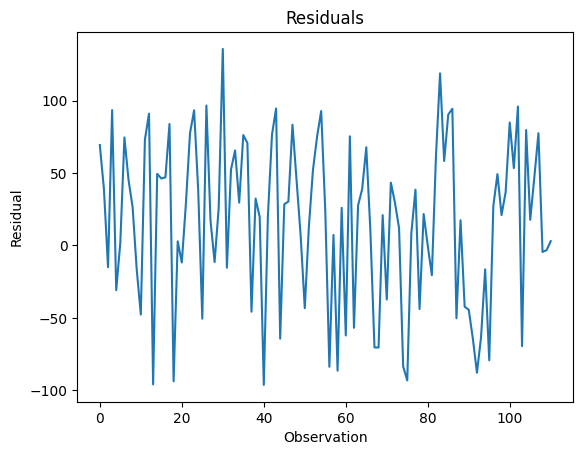

In [ ]:
# The recommended way to get started using MLflow tracking with Python is to use the MLflow autolog() API.
# With MLflow’s autologging capabilities, a single line of code automatically logs the resulting model, the parameters used to create the model, and a model score.
mlflow.sklearn.autolog(log_models=False)

# This time I want to use a specific experiment
mlflow.set_experiment("/My Amazing Experiment")
 
# With autolog() enabled, all model parameters, a model score, and the fitted model are automatically logged.
# It's also possible to pass a run name like  mlflow.start_run(run_name="My amazing run"), otherwise MLflow will choose one for us 
with mlflow.start_run():
  # Set the model parameters. 
  n_estimators = 10
  max_depth = 5
  max_features = 3

  # Create and train model.
  rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features)
  rf.fit(X_train, y_train)

  # Use the model to make predictions on the test dataset.
  predictions = rf.predict(X_test)

  # Log the model parameters used for this run.
  mlflow.log_param("num_trees", n_estimators)
  mlflow.log_param("maxdepth", max_depth)
  mlflow.log_param("max_feat", max_features)

  # Define a metric to use to evaluate the model.
  mse = mean_squared_error(y_test, predictions)
    
  # Log the value of the metric from this run.
  mlflow.log_metric("mse", mse)

  # We can even explicitly log the model created by this run with its signature
  mlflow.sklearn.log_model(rf, "model", signature=signature)

  # Convert the residuals to a pandas dataframe to take advantage of graphics capabilities
  df = pd.DataFrame(data = predictions - y_test)
  # Create a plot of residuals
  plt.plot(df)
  plt.xlabel("Observation")
  plt.ylabel("Residual")
  plt.title("Residuals")

  # Save the plot figure
  fig = plt.gcf()
  mlflow.log_figure(fig, "residuals_plot.png")

mlflow.end_run()

In [ ]:
# deploy the model locally
# ! mlflow models serve --env-manager=local -m runs:/ -p 5001